# Wasserstein GAN в задаче идентификации аномалий в геофизических данных
<br /><br />
В этом исследовании предлагается применить WGAN для идентификации аномалий в данных, описывающих состояние стратосферы на уровне 10гПа в северном полушарии.
<br /><br />
Известно, что обычно состояние стратосферы над северным полушарием в зимний период описывается как стратосферный полярный вихрь (СПВ). Это вихрь, образующийся под действием силы Кориолиса при условии выхолаживания полярной области стратосферы и, как следствие, возникновения градиента давления между полярной областью и умеренными широтами.

### Исходные данные
В этом исследовании состояние стратосферы будет описываться полями потенциальной завихренности (переменная `pv`) и высоты геопотенциала (переменная `gh`) на уровне 10гПа. Эти данные ограничены по широте: в исходных файлах представлены значения севернее $40^\circ$N, спроецированные с использованием полярной проекции. Кроме того, исходные данные уже отнормированы к интервалу $[0,1]$. Примеры полученного таким образом признакового описания состояний стратосферы приведены на рисунке ниже.
<br /><br />
Исходные данные исследования можно скачать по следующим ссылкам: [pv data](https://www.dropbox.com/s/ohwfyrmj4zl94q9/pv_data_projected_all.normed01.npy?dl=0); [gh data](https://www.dropbox.com/s/v3qjgzsls6et6cw/hgt_data_projected_all.normed01.npy?dl=0)
<br />
Маску для исключения несущественных зон снимка из рассмотрения можно скачать по ссылке: [mask data](https://www.dropbox.com/s/7s6lgdi01f8plkz/mask_256.npy?dl=0)

# <b> Comment START </b>
Для выделения моих мыслей/комментариев среди иной информации здесь и далее будет использоваться такая отметка.

Сразу хочу отметить, что долгий срок сдачи связан с тем, что хотелось докрутить её до рабочего состояния, хотя в целом весь рабочий код был написан до срока дедлайна (14 июня). Однако используемые архитектуры не создавали нужное распределение в латентном пространстве. Хотелось разобраться и побороть эту проблему, но сейчас при параллельной работе над финальным проектом не хочется распыляться, поэтому сдаю то, что есть. Возможно ещё вернусь к этой задаче и добью её. Возможно с помощью каких-то иных подходох (VAE/ Unsupervised методы на основе трансформеров).

Пара слов в целом про полученные результаты (что получилось, что нет) - использовались архитектуры с линейными слоями, DCGAN (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), FCCGAN(https://arxiv.org/pdf/1905.02417.pdf), архитектура по типу Progressive-GAN (но до реализации прогрессивного обучения руки не дошли, тч она обучалась вся одновременно).      
Кроме перебора архитектур, проверялись следующие параметры:     
Оптимизаторы дискриминатора - AdaM/SGD     
Нормализация в дискриминаторе - без неё/BatchNorm/LayerNorm/InstanceNorm     
Loss-function - WGAN-GP/GAN(BCELoss)      
Параметр lambda у Gradient Penalty

# <b> Comment END

In [1]:
!wget https://www.dropbox.com/s/7s6lgdi01f8plkz/mask_256.npy
!wget https://www.dropbox.com/s/ohwfyrmj4zl94q9/pv_data_projected_all.normed01.npy
!wget https://www.dropbox.com/s/v3qjgzsls6et6cw/hgt_data_projected_all.normed01.npy

--2021-06-28 17:30:32--  https://www.dropbox.com/s/7s6lgdi01f8plkz/mask_256.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7s6lgdi01f8plkz/mask_256.npy [following]
--2021-06-28 17:30:32--  https://www.dropbox.com/s/raw/7s6lgdi01f8plkz/mask_256.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95ea49fcdd5d75f5e42ce75441.dl.dropboxusercontent.com/cd/0/inline/BRSQLQZ85_TuQSeJBoM0kyzZBWtu3IBxmmvhR8uNwg45Xc78XPLx__U1937Wg90sjtWV0jYsxKkf4Hz6YTSpE8AI6kZgbpQTv_zHXkA0sEMvHzTeHepwyaP9ydp5pD2k7zFAnp2R2XOZKsaXpgvMlzP7/file# [following]
--2021-06-28 17:30:32--  https://uc95ea49fcdd5d75f5e42ce75441.dl.dropboxusercontent.com/cd/0/inline/BRSQLQZ85_TuQSeJBoM0kyzZBWtu3IBxmmvhR8uNwg45Xc78XPLx__U1937Wg90sjtWV0jYsxKkf4Hz6YTSpE8AI6k

In [ ]:
ls

sample_data/


<center><img src="img/source_data_example.png" width=600></center>

### Внезапные стратосферные потепления как аномалии
Примерно с частотой один раз в 1.6 лет состояние стратосферы кардинально меняется, и сильный устойчивый вихрь, видный на диаграмме выше, распадается совсем или как минимум сильно возмущается и смещается с полюса. Эти состояния редки, и именно поэтому в этом исследовании будем считать их аномалиями. Цель исследования - применить набор нейросетевых моделей для поиска таких аномалий.

# Порождающие состязательные сети
Порождающие состязательные сети (ПСС, Generative Adversarial Networks, GAN) - нейросетевые модели, отличающиеся от обычных дискриминативных моделей в смысле методики обучения и сэмплирования данных.

<center><img src="img/GAN_en.png" width=600></center>

Терминология в GAN включает "реальные объекты" (real objects) - такие, которые порождены реальным процессом и даны в форме обучающей выборки, и "фейковые" или "порожденные" объекты (fake objects) - такие, которые являются результатом вычисления генератора $\mathcal{G}(\mathbb{\cdot})$ на входных данных $z$. При этом входные данные $z$ - это шум, порожденный из специального распределения. Обычно берут многомерное стандартное нормальное распределение. Порождаемые векторы шума (noise) также называют векторами скрытого представления (hidden representations или embeddings) по аналогии с терминологией автокодировщиков. В этом смысле генератор GAN - аналог декодера.

При этом дискриминатор $\mathcal{D}(\mathbb{\cdot})$ - подсеть, задача которой различать реальные и фейковые объекты, базируясь на их признаковом представлении. В определенном смысле дискриминатор - всего лишь нейросеть, решающая задачу бинарной классификации между реальными и фейковыми объектами.

Принцип обучения GAN состоит в том, что две подсети (генератор и дискриминатор) должны решать две противоположные задачи: генератор должен порождать примеры, настолько похожие на реальные, чтобы дискриминатор не мог их различить; при этом дискриминатор должен учиться все равно различать эти примеры.

Обозначения, которые вводятся для GAN:
- $z$ - шумовой вектор (noise) в пространстве скрытых представлений $\mathbb{Z}$;
- $x$ - признаковое описание реального объекта (!!! именно в пространстве признаков $\mathbb{X}$ !!!);
- $\mathcal{G}(z)$ - генератор, нейросеть, порождающая "фейковые" объекты из векторов $z$. Генератор переводит векторы пространства $\mathbb{Z}$ в векторы пространства $\mathbb{X}$:
$$
\mathcal{G}(\mathbf{\cdot}): \mathbb{Z}\to\mathbb{X}
$$
- $\mathcal{D}(x)$ - дискриминатор, нейросеть, решающая задачу классификации векторов пространства $\mathbb{X}$ на "реальные" и "фейковые".

Псевдоалгоритм обучения GAN:
<br /><br />
<center><img src="img/gan_algo.png" width=600></center>

Исходный алгоритм обучения GAN оказался нестабильным, и для его стабилизации были предложены усовершенствования, получившие название Wasserstein GAN ([WGAN](https://arxiv.org/abs/1701.07875)).
<br />
обозначения, принятые в этой статье:
- $g(z)$ - генератор;
- $f(x)$ - дискриминатор.
<br /><br />
Псевдоалгоритм обучения WGAN:
<br /><br />
<center><img src="img/wgan_algo.png" width=600></center>

В дальнейшем был предложен усовершенствованный алгоритм обучения WGAN с наложением ограничений на градиент дискриминатора $\mathcal{D}(x)$ по входным данным $x$ - Wasserstein GAN with Gradient Penalty ([WGAN-GP](https://arxiv.org/abs/1704.00028))
<br /><br />
Псевдоалгоритм обучения WGAN-GP:
<center><img src="img/wgan-gp-algo.png" width=600></center>

<hr>

В этом задании предлагается обратить внимание на свойство GAN аппроксимировать распределение данных. Это можно интуитивно понять на примере следующей пары диаграмм:
<center><img src="img/WGAN-mapping.png" width=600></center>

Здесь на левой панели условно отображены векторы скрытых представлений $z$ в пространстве скрытых представлений $\mathbb{Z}$. Напомним, что эти векторы порождаются из стандартного нормального распределения. На правой панели диаграммы условно отображаются объекты $x$ в пространстве признакового описания объектов $\mathbb{X}$. Здаесь они отображены в двумерном пространстве, однако нужно помнить, что в предлагаемой задаче это векторы в пространстве размерности `2*256*256`, поскольку признаковое описание состояний стратосферы составлено двумя полями (`pv` и `gh`), каждое из которых представляет собой матрицу размером `256x256`.

На диаграмме условно отображено соответствие областей в пространствах $\mathbb{Z}$ и $\mathbb{X}$, в которых сосредоточена основная часть объектов выборки (точки оранжевого цвета). Точками синего цвета условно отображены объекты, являющиеся выбросами (аномалиями) для данных выборки. С точки зрения распределения переменной $z$ эти объекты лежат за пределами основной массы распределения, то есть, могут быть интерпретированы, например, как векторы, норма которых больше перцентиля уровня $98\%$. В это же время, в пространстве признакового описания $\mathbb{X}$ соответствующие объекты, вычисляемые как $\mathcal{G}(z)$ могут считаться аномалиями (синие точки на правой панели диаграммы).

С точки зрения задачи идентификации аномалий в этом случае остается только один вопрос: **как в пространстве $\mathbb{X}$ построить разделяющую поверхность**, соответствующую разделяющей поверхности, проходящей по перцентилю $98\%$ нормы векторов $z$ в пространстве $\mathbb{Z}$. Это при условии, что **вряд ли найдется возможность обратить преобразование генератора и получить $\mathcal{G}^{-1}(x)$**. А именно такое преобразование понадобилось бы для того, чтобы протестировать вновь поступающие на анализ события $x\in\mathbb{X}$ на принадлежность области "обычных" или "аномальных" объектов в пространстве $\mathbb{Z}$.

#### Применение WGAN-GP для порождения сбалансированной выборки "обычных" и "аномальных" объектов

В качестве альтернативного решения такой задачи в этом задании (во второй части) предлагается создать нейросетевой классификатор $\mathcal{F}(x)$, способный разделять объекты $x$ на обычные, характерные для выборки, и аномальные. Вопрос в том, - как его обучить?

В случае, когда в нашем распоряжении есть генератор $\mathcal{G}(z)$, обученный порождать как "обычные" объекты, так и "аномальные", можно сгенерировать достаточное количество обучающих примеров для такого бинарного классификатора $\mathcal{F}(x)$. При этом метка $y_i$ "обычный"/"аномальный" будет доступна по условию порождения таких примеров: в силах исследователя в момент генерации шумового вектора $z_i$ классифицировать его, руководствуясь его нормой:

- Если $|z_i|_2>q_{0.98}(|z|_2)$, то объект может считаться аномальным, $y_i=1$
- Иначе объект может считаться обычным, $y_i=0$

Отметим также, что в силах исследователя регулировать порождение сбалансированной выборки, что важно для обучения надежного классификатора. Для этого на этапе порождения векторов $z$ следует следить за сбалансированностью их с точки зрения классификации на "обычные" и "аномальные".

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
#from libs.service_defs import *
import torch.autograd as autograd
from scipy import stats
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import torchvision.transforms as tt
from PIL import Image

from typing import Tuple, List, Type, Dict, Any

from PIL import Image
from IPython.display import clear_output
from torchvision.utils import make_grid

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Проверим доступность GPU
torch.cuda.device_count()

1

In [6]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [7]:
pv = np.load('pv_data_projected_all.normed01.npy', mmap_mode='r')
gh = np.load('hgt_data_projected_all.normed01.npy', mmap_mode='r')
mask = np.load('mask_256.npy', mmap_mode='r')
#_ = torch.tensor(mask).to(DEVICE)

In [8]:
def create_mask(size):
  size = size//2
  mask = np.ones((size,size))
  for i in range(size):
    for j in range(size):
      if i**2 + j**2 > size**2:
        mask[i][j] = 0
  mask_tmp = np.rot90(mask)
  mask = np.concatenate((mask_tmp, mask))
  mask_tmp = np.flip(mask)
  mask = np.concatenate((mask_tmp, mask), axis = 1)
  return mask

In [9]:
mask_128 = create_mask(128)

0.40346643

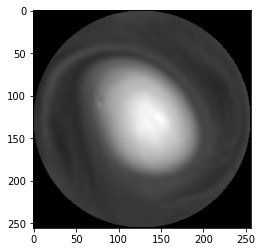

In [10]:
plt.imshow(pv[1000]*mask, cmap='gray')
np.min(gh[1])

In [11]:
class DS(Dataset):
    def __init__(self,
                 pv_fname: str = '',
                 gh_fname: str = '',
                 mask_fname: str = '',
                 transform: Any = None):
        
        '''
        здесь должен быть код инициализациия экземпляра класса DS
        В нем следует считать данные и записать в виде атрибутов этого экземпляра класса
        Также следует сохранить в качестве атрибута этого экземпляра класса преобразование(я) transform,
            которые должны будут применяться к данным
        
        '''
        ################################
        ###    YOUR CODE HERE        ###
        ################################
        self.pv = np.load(pv_fname, mmap_mode='r')
        self.gh = np.load(gh_fname, mmap_mode='r')
        self.mask = np.load(mask_fname, mmap_mode='r')
        self.transform = transform
        

    def __getitem__(self, index):
        x = np.zeros((2,256,256))
        '''
        Здесь должно быть описание процедуры составления (возможно, из заранее прочитанных данных)
            признакового описания запрашиваемого по индексу index объекта,
            а также применения преобразований transform, если они есть.
        Этот метод должен выдавать признаковое описание объекта.
        Подсказка: размерность признакового описания одного объекта должна быть [1,2,256,256], где
        1 - нумерует (единственный) объект в этой выборке
        2 - нумерует "каналы" данных (pv и gh)
        256,256 - индексирует пространственные переменные
        '''
        x[0] = self.pv[index] * mask
        x[1] = self.gh[index] * mask

        if self.transform:
            #x = Image.fromarray((x.transpose(1,2,0) * 255).astype(np.uint8))
            x = self.transform(x)
            #x = x * mask_128

  
      

        return x
    

    def __len__(self):
        length = 0
        '''
        Этот метод должен возвращать полное количество объектов в выборке
        '''

        length = len(self.pv)

        return length

In [12]:
#image_size = 128
#train_transforms = tt.Compose([
              #tt.Resize(image_size),
#              tt.ToTensor()])
train_transforms = lambda x: Tensor(x)

In [13]:
train_dataset = DS('pv_data_projected_all.normed01.npy',
                   'hgt_data_projected_all.normed01.npy',
                   'mask_256.npy',
                   train_transforms)

Для контроля можно отобразить порождаемые этим классом объекты:

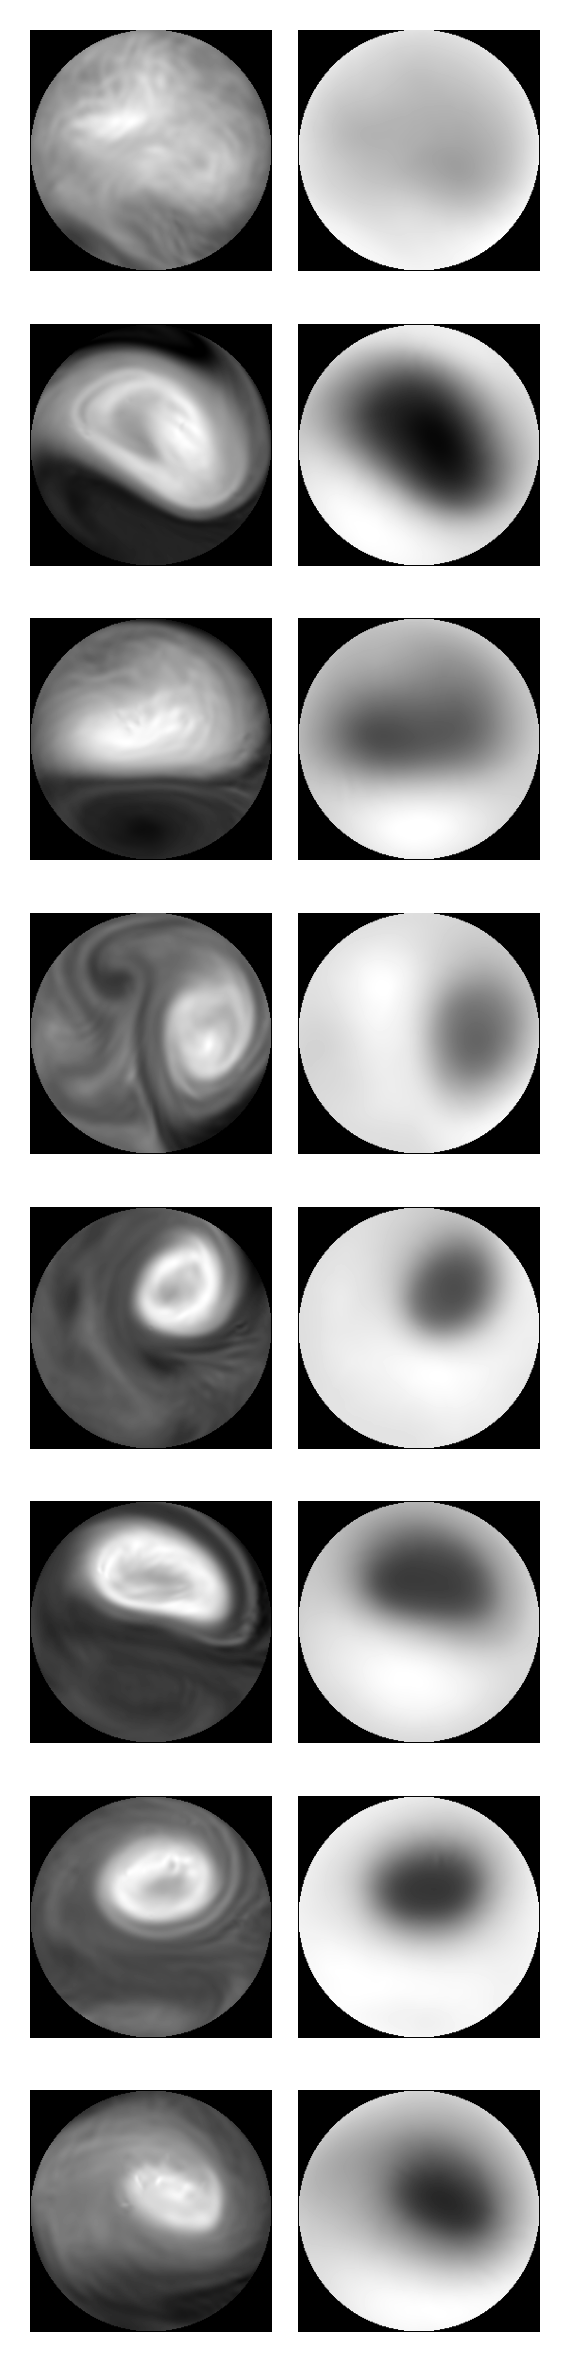

In [14]:
indices = np.random.randint(0, len(train_dataset), size=8)
samples = [train_dataset[idx] for idx in indices]

fig = plt.figure(figsize=(2, 8), dpi=300)
for idx,sample in enumerate(samples):
    sample_np = sample.cpu().numpy()
    p = plt.subplot(8,2,idx*2+1)
    plt.imshow(sample_np[0], cmap='gray')
    plt.axis('off')
    
    p = plt.subplot(8,2,idx*2+2)
    plt.imshow(sample_np[1], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
fig.patch.set_facecolor('white')

Далее следует описать подсети генератора $\mathcal{G}(\cdot)$ и дискриминатора $\mathcal{D}(\cdot)$

Напомним, генератор принимает на вход вектор размерности `n_inputs` (в случае мини-батча размером `N` - матрицу `N x n_inputs`) и возвращает тензор размером `N x 2 x 256 x 256`

При этом дискриминатор принимает на вход тензоры размером `N x 2 x 256 x 256` и действует как бинарный классификатор: выходное значение - одно действительное число на каждый объект. То есть, размерность выходного тензора должна быть `N x 1`. В случае WGAN-GP это выходное значение не ограничивается по величине и может принимать все действительные значения (подумайте, какая в этом случае должна быть функция активации выходного слоя).

ConvTranspose2d:
$$
H_{out} = (H_{in} - 1) * stride - 2*padding + dilation*(kernel\_size - 1) + 1 $$    

In [15]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, n_inputs=256):
        super(Generator, self).__init__()
        
        ################################
        ###    YOUR CODE HERE        ###
        ################################

        self.model = nn.Sequential(
          # in: latent_size x 1 x 1
            nn.Flatten(),
            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Unflatten(1, (256,1,1)),

            nn.ConvTranspose2d(n_inputs, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 4 x 4

            nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8 

            nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            # out: 256 x 16 x 16    

            nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 32 x 32

            nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            # out: 64 x 64 x 64

            nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            # out: 32 x 128 x 128


            nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 2, kernel_size=1, stride=1, padding=0, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # out: 2 x 256 x 256
        )

    def forward(self, input):
        return self.model(input)

Conv2d:
$$
H_{out} = \frac{H_{in} + 2*padding - dilation*(kernel\_size - 1) -1}{stride} + 1 $$   
ConvTranspose2d:

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # in: 2 x 256 x 256

            nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1, bias=False),
            #nn.InstanceNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.InstanceNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 16 x 128 x 128
            
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, bias=False),
            #nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 32 x 32 x 32

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 4 x 4


            nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 1 x 1

            nn.Flatten(),
            nn.Linear(in_features=256, out_features=1, bias=True)
            # out: 1 x 1 x 1

    #         nn.Flatten()
    )

    def forward(self, input):
        return self.main(input)

Далее применим описанные классы генератора и дискриминатора для создания WGAN-GP:

In [17]:
latent_dim = 256

In [18]:
gen = Generator(n_inputs=latent_dim)
gen.load_state_dict(torch.load("drive/MyDrive/WGAN_gen.pth"))
gen = gen.to(DEVICE)

In [19]:
dsc = Discriminator()
dsc.load_state_dict(torch.load("drive/MyDrive/WGAN_dsc.pth"))
dsc = dsc.to(DEVICE)

In [ ]:
sum(p.numel() for p in gen.parameters())

3456224

In [ ]:
sum(p.numel() for p in dsc.parameters())

1941281

In [20]:
# Также следует создать оптимизаторы отдельно для генератора и для дискриминатора
opt_gen = torch.optim.Adam(gen.parameters(), lr=5e-8) # YOUR CODE HERE
opt_dsc = torch.optim.SGD(dsc.parameters(), lr=5e-8, momentum=0.9) # YOUR CODE HERE

Для модели WGAN-GP применяется регуляризация на градиент выхода дискриминатора по его входным данным. Здесь предлагается воспользовать его реализацией, приведенной ниже:

In [21]:
def compute_gradient_penalty(model_dsc, real_samples, fake_samples):
    """
    Calculates the gradient penalty loss for WGAN GP
    model_dsc - дискриминатор
    real_samples - признаковое описание реальных примеров
    fake_samples - признаковое описание примеров, порожденных генератором.
    """
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = model_dsc(interpolates)
    fake = Variable(Tensor(d_interpolates.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates,
                              inputs=interpolates,
                              grad_outputs=fake,
                              create_graph=True,
                              retain_graph=True,
                              only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [22]:
def train_model(model_gen: torch.nn.Module, 
                model_dsc: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                optimizer_gen: torch.optim.Optimizer,
                optimizer_dsc: torch.optim.Optimizer,
                batch_size = 24,
                max_epochs = 10,
                n_critic = 5,
                lambda_gp = 10):
    
    '''
    В этой функции следует запрограммировать обучение и валидацию WGAN-GP.
    
    '''
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size) # YOUR CODE HERE
    
    lr_scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gen, T_max = 10) # YOUR CODE HERE
    lr_scheduler_dsc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_dsc, T_max = 10) # YOUR CODE HERE
        
    # Полезно будет записать эволюцию функций потерь по ходу обучения - ее можно будет потом отобразить на диаграмме
    val_loss_history = []
    gen_loss_history = []
    dsc_loss_history = []
    real_score_history = []
    fake_score_history = []
    loss_gen = 0.0
    loss_dsc = 0.0
    
    fixed_latent = torch.randn(36, latent_dim, 1, 1, device=DEVICE)
    
    # Далее следует написать цикл оптимизации генератора и дискриминатора,
    # руководствуясь псевдоалгоритмом, приведенным в описании выше
    # Замечание: Не забудьте применить маску как к реальным данным (это можно сделать в генераторе данных DS),
    #           так и к данным, порождаемым генератором!
    
       
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')
        
        model_gen.train()
        model_dsc.train()
        
        val_point = Variable(torch.tensor(np.random.normal(0, 1, (2, latent_dim, 1, 1)), dtype=torch.float, device=DEVICE))

        with tqdm(total=len(train_loader)) as pbar:
            for idx, real_batch in enumerate(train_loader):
                
                ################################
                ###    YOUR CODE HERE        ###
                ################################
                # шаг оптимизации дискриминатора
                optimizer_dsc.zero_grad()

                real_batch = real_batch.float().to(DEVICE)
                noise = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), latent_dim, 1, 1)), dtype=torch.float, device=DEVICE))
                fake_batch = model_gen(noise)
                
                fake_batch = torch.mul(fake_batch, torch.tensor(mask).to(DEVICE)).float()
                # print(np.min(np.array(fake_batch[0][0].cpu().detach().numpy())))
                # print(np.min(np.array(real_batch[0][0].cpu().detach().numpy())))
                # print(np.max(np.array(fake_batch[0][0].cpu().detach().numpy())))
                # print(np.max(np.array(real_batch[0][0].cpu().detach().numpy())))

                real_scores = model_dsc(real_batch)
                fake_scores = model_dsc(fake_batch)
                gradient_penalty = compute_gradient_penalty(dsc, real_batch, fake_batch)

                loss_dsc = -torch.mean(real_scores) + torch.mean(fake_scores) + lambda_gp * gradient_penalty
                dsc_loss_history.append(loss_dsc)

                loss_dsc.backward()
                optimizer_dsc.step()

                if idx % n_critic == 0:
                    
                    ################################
                    ###    YOUR CODE HERE        ###
                    ################################
                    # шаг оптимизации генератора
                    optimizer_gen.zero_grad()

                    fake_batch = model_gen(noise)
                    fake_batch = torch.mul(fake_batch, torch.tensor(mask).to(DEVICE)).float()

                    fake_scores = model_dsc(fake_batch)
                    loss_gen = -torch.mean(fake_scores)

                    for i in range (n_critic):
                      gen_loss_history.append(loss_gen)

                    loss_gen.backward()
                    optimizer_gen.step()

                    # pbar.update(1)
                    # pbar.set_postfix({'step': idx + 1, 'loss_GEN': loss_gen.item(), 'loss_DSC': loss_dsc.item()})
                  
                if (idx) % 100 == 0:

                   # Visualize tools
                    clear_output(wait=True)
                    # fig, ax = plt.subplots(figsize=(12, 12))
                    # ax.set_xticks([]); ax.set_yticks([])
                    X_val_pred = model_gen(fixed_latent)
                    fig = plt.figure(figsize=(2, 2), dpi=300)
                    for i in range(X_val_pred.shape[0]):
                      plt.subplot(6,6,i+1)
                      plt.imshow(X_val_pred.cpu().detach()[i,0,:,:] * mask, cmap='gray')
                      plt.axis('off')

                    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
                    ax = ax.flatten()
                    #Losses
                    ax[0].plot(dsc_loss_history, '-o')
                    ax[0].plot(gen_loss_history, '-o')
                    ax[0].set_xlabel('steps/100')
                    ax[0].set_ylabel('loss')
                    ax[0].legend(['Discriminator', 'Generator'])
                    ax[0].set_title('Losses')
                    #Scores
                    ax[1].plot(real_scores.cpu().detach(), '-o')
                    ax[1].plot(fake_scores.cpu().detach(), '-o')
                    ax[1].set_xlabel('steps/100')
                    ax[1].set_ylabel('loss')
                    ax[1].legend(['Real', 'Fake'])
                    ax[1].set_title('Scores')
                    plt.tight_layout()
                    plt.show()

                real_score_history.append(torch.mean(real_scores))
                fake_score_history.append(torch.mean(fake_scores))
                pbar.update(1)
                
                pbar.set_postfix({'step': idx+1, 'loss_GEN': loss_gen.item(), 'loss_DSC': loss_dsc.item(), 
                                  'real_score': torch.mean(real_scores).item(), 'fake_score': torch.mean(fake_scores).item()})
                
        # Тут рекомендуется сохранять модели каждую эпоху

        torch.save(model_gen.state_dict(), "drive/MyDrive/WGAN_gen.pth")
        torch.save(model_dsc.state_dict(), "drive/MyDrive/WGAN_dsc.pth")
        
        # Валидация - оценка функции потерь WGAN-GP (без регуляризационного члена) как D(x_real) - D(x_fake)
        
        model_gen.eval()
        model_dsc.eval()
        
        ################################
        ###    YOUR CODE HERE        ###
        ################################
        val_loss_epoch = []
        VAL_STEPS = 10
        VAL_BATCH_SIZE = 32
        with tqdm(total=VAL_STEPS) as pbar:
          for idx in range(VAL_STEPS):
              real_batch = iter(train_loader).next().float().to(DEVICE)
              noise = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), latent_dim, 1, 1)), dtype=torch.float, device=DEVICE))
              fake_batch = gen(noise)
              fake_batch = torch.mul(fake_batch, torch.tensor(mask).to(DEVICE)).float()
              val_loss_epoch.append((torch.mean(dsc(real_batch) - dsc(fake_batch))).detach().cpu())
              pbar.update(1)

        val_loss_epoch = np.sum(val_loss_epoch)/(VAL_STEPS*VAL_BATCH_SIZE)
        
        val_loss_history.append(val_loss_epoch)
        
        lr_scheduler_gen.step()
        lr_scheduler_dsc.step()
        
    return val_loss_history, dsc_loss_history, gen_loss_history, real_score_history, fake_score_history

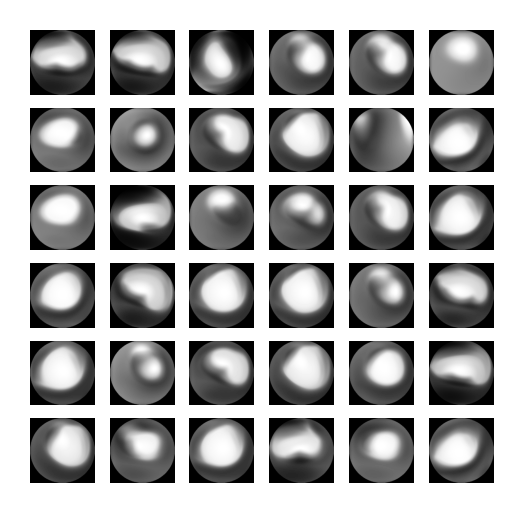

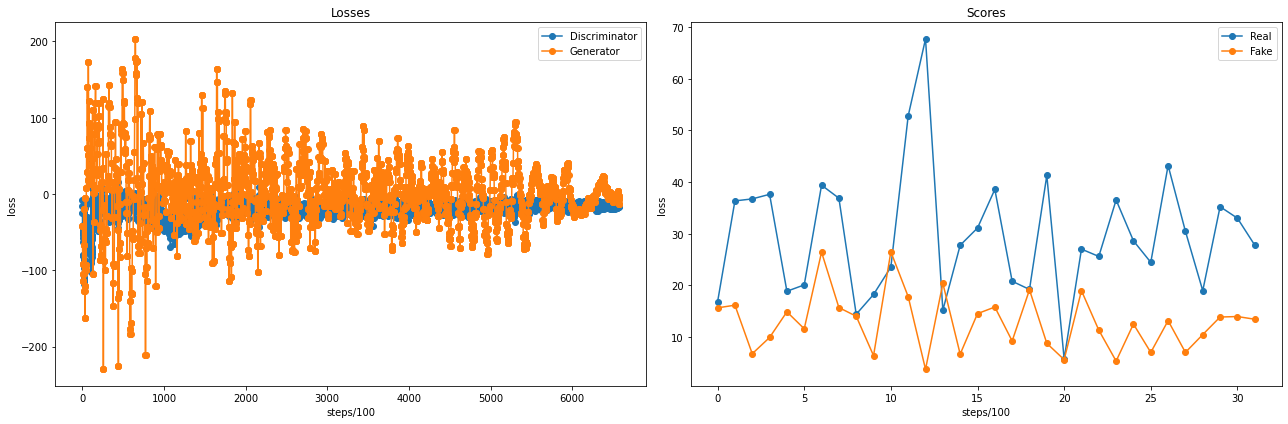

100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


In [ ]:
loss_history, dsc_loss_history, gen_loss_history, real_score_history, fake_score_history = train_model(gen, dsc,
                                                               train_dataset,
                                                               opt_gen, opt_dsc,
                                                               batch_size = 32,
                                                               max_epochs=10,
                                                               n_critic=4,
                                                               lambda_gp=10)

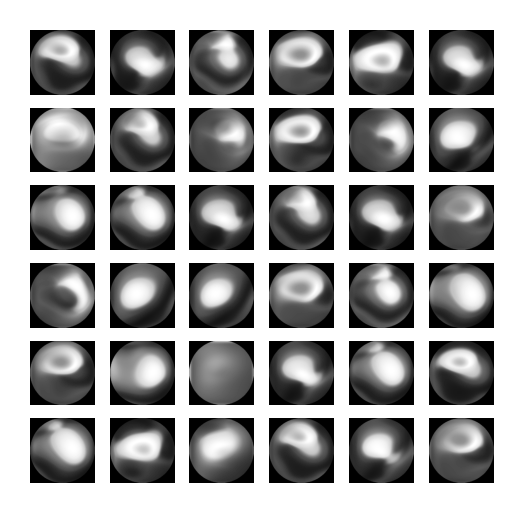

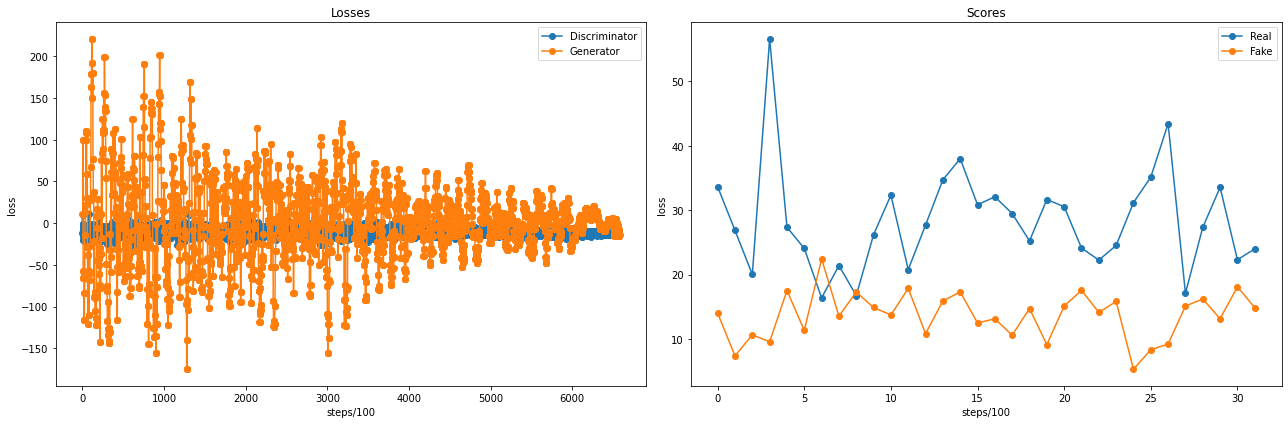

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


In [ ]:
loss_history, dsc_loss_history, gen_loss_history, real_score_history, fake_score_history = train_model(gen, dsc,
                                                               train_dataset,
                                                               opt_gen, opt_dsc,
                                                               batch_size = 32,
                                                               max_epochs=10,
                                                               n_critic=4,
                                                               lambda_gp=10)

In [ ]:
# Также следует создать оптимизаторы отдельно для генератора и для дискриминатора
opt_gen = torch.optim.Adam(gen.parameters(), lr=5e-6) # YOUR CODE HERE
opt_dsc = torch.optim.SGD(dsc.parameters(), lr=5e-6, momentum=0.9) # YOUR CODE HERE

In [ ]:
# Также следует создать оптимизаторы отдельно для генератора и для дискриминатора
opt_gen = torch.optim.Adam(gen.parameters(), lr=5e-7) # YOUR CODE HERE
opt_dsc = torch.optim.SGD(dsc.parameters(), lr=5e-7, momentum=0.9) # YOUR CODE HERE

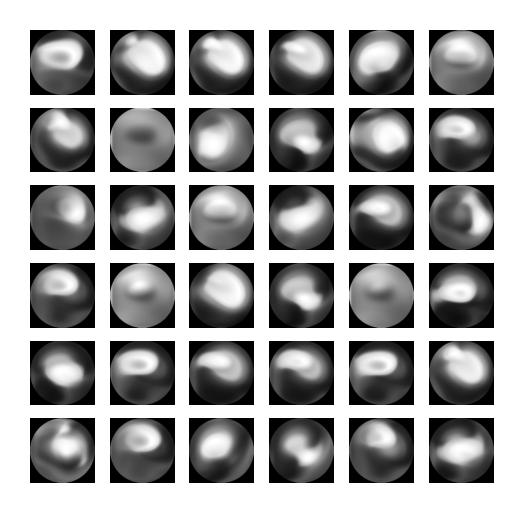

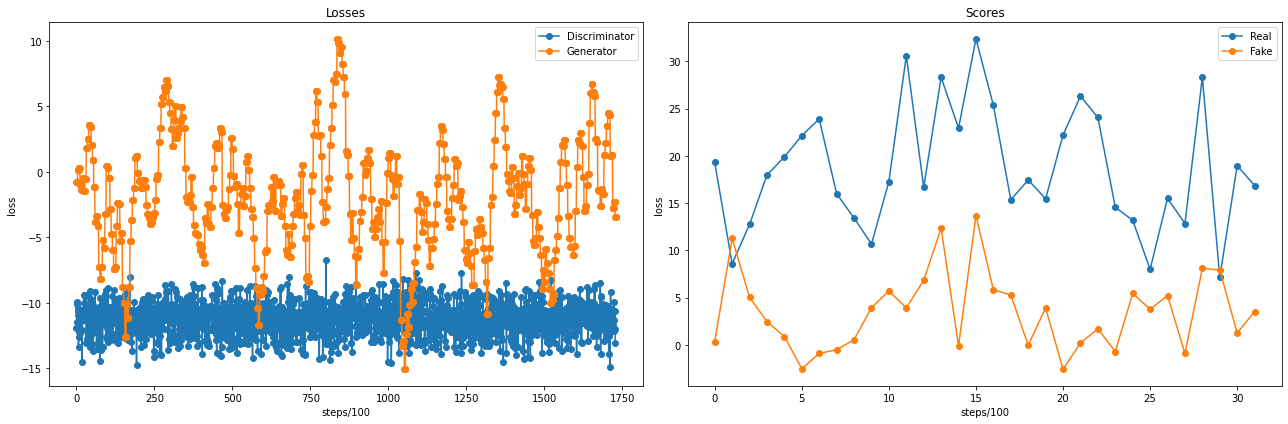

 71%|███████   | 471/664 [08:24<03:27,  1.07s/it, step=470, loss_GEN=-1.47, loss_DSC=-9.88, real_score=15.9, fake_score=3.82]

In [ ]:
loss_history, dsc_loss_history, gen_loss_history, real_score_history, fake_score_history = train_model(gen, dsc,
                                                               train_dataset,
                                                               opt_gen, opt_dsc,
                                                               batch_size = 32,
                                                               max_epochs=10,
                                                               n_critic=4,
                                                               lambda_gp=10)

# <b> Comment START </b>
Видно, что полученные с использование WGAN картинки не отображают какие-то мелкие детали, поэтому дискриминатор даёт ответы вполне сдвинутые друг от друга для реальных и сгенерированных картинок.           
Однако, стоит заметить, что тут себя очень хорошо показал обычный GAN без GP, который дал следующие результаты (картинка):

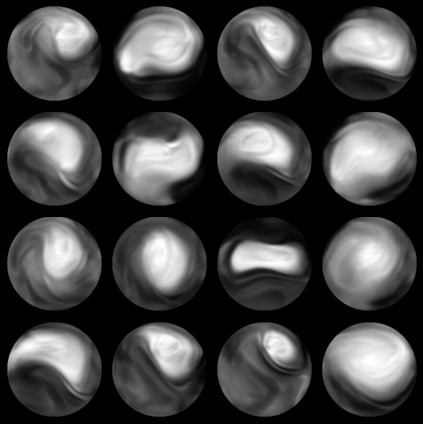

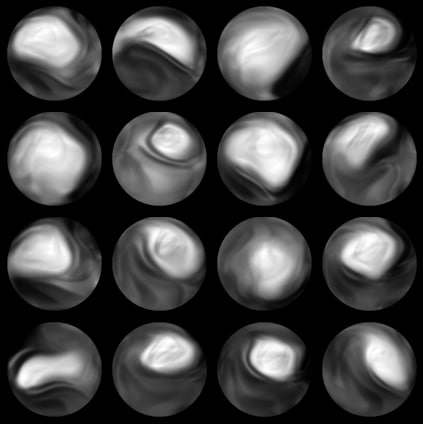

Он генерировал очень хорошие результаты и при этом Mode Collapse не происходил.     
Однако, основной проблемой было то, что разделения картинок до и после 98 перцентиля не происходило.    
На данных картинках результаты сверху внутри 98 перцентиля, снизу - вне его.

<b> P.S. </b> Если учить GAN очень долго (а я это пробовал), Mode Collapse всё таки происходит. Картинка ниже

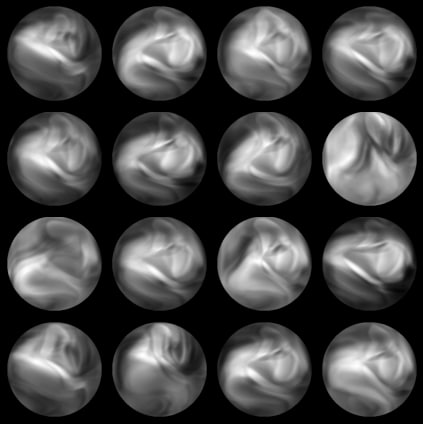

# <b> Comment END 

Для оценки качества обучения, полезно посмотреть на кривые обучения:

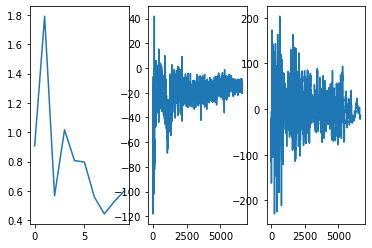

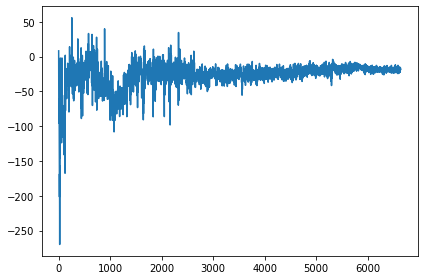

In [ ]:
#f = plt.figure(figsize=(8,3), dpi=300)
p = plt.subplot(1,3,1)
_ = plt.plot(np.arange(len(loss_history)), loss_history)

p = plt.subplot(1,3,2)
#dsc_loss_history[0].cpu()
to_cpu = lambda x: [i.cpu().detach().numpy() for i in x]
#dsc_loss_history = to_cpu(dsc_loss_history)
_ = plt.plot(np.arange(len(dsc_loss_history)), dsc_loss_history)

p = plt.subplot(1,3,3)
#gen_loss_history = to_cpu(gen_loss_history)
_ = plt.plot(np.arange(len(gen_loss_history)), gen_loss_history)
plt.show()

# plt.plot(np.arange(len(real_score_history)), real_score_history)
# plt.plot(np.arange(len(fake_score_history)), fake_score_history)
plt.plot(np.arange(len(fake_score_history)), np.array(fake_score_history) - np.array(real_score_history))
plt.tight_layout()

Далее предлагается применить генератор для порождения новых примеров и оценить их правдоподобность.

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

In [25]:
for idx, real_batch in enumerate(train_loader):
    break

In [26]:
# # При необходимости можно загрузить нужное состояние генератора
# gen = Generator(n_inputs=latent_dim)
# gen.load_state_dict(torch.load('./path/to/model/checkpoint/gen.pt'))
# gen = gen.to(DEVICE)

In [27]:
gen.eval()
real_batch = real_batch.to(DEVICE)
noise = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), latent_dim, 1, 1)),
                              dtype=torch.float, device=DEVICE))

fake_batch = gen(noise)

# plt.figure(figsize=(10,7))
# p = plt.subplot(2,1,1)
# plt.imshow(fake_batch[0][0].cpu().detach().numpy()* mask, cmap = 'gray')
# p = plt.subplot(2,1,2)
# plt.imshow(fake_batch[0][1].cpu().detach().numpy(), cmap = 'gray')
# Замечание: Не забудьте применить маску к данным, порождаемым генератором!
################################
###    YOUR CODE HERE        ###
################################
fake_batch = fake_batch.cpu().detach().numpy() * mask

In [28]:
real_batch = real_batch.detach().cpu().numpy()
#fake_batch = fake_batch.detach().cpu().numpy()

(-0.5, 255.5, 255.5, -0.5)

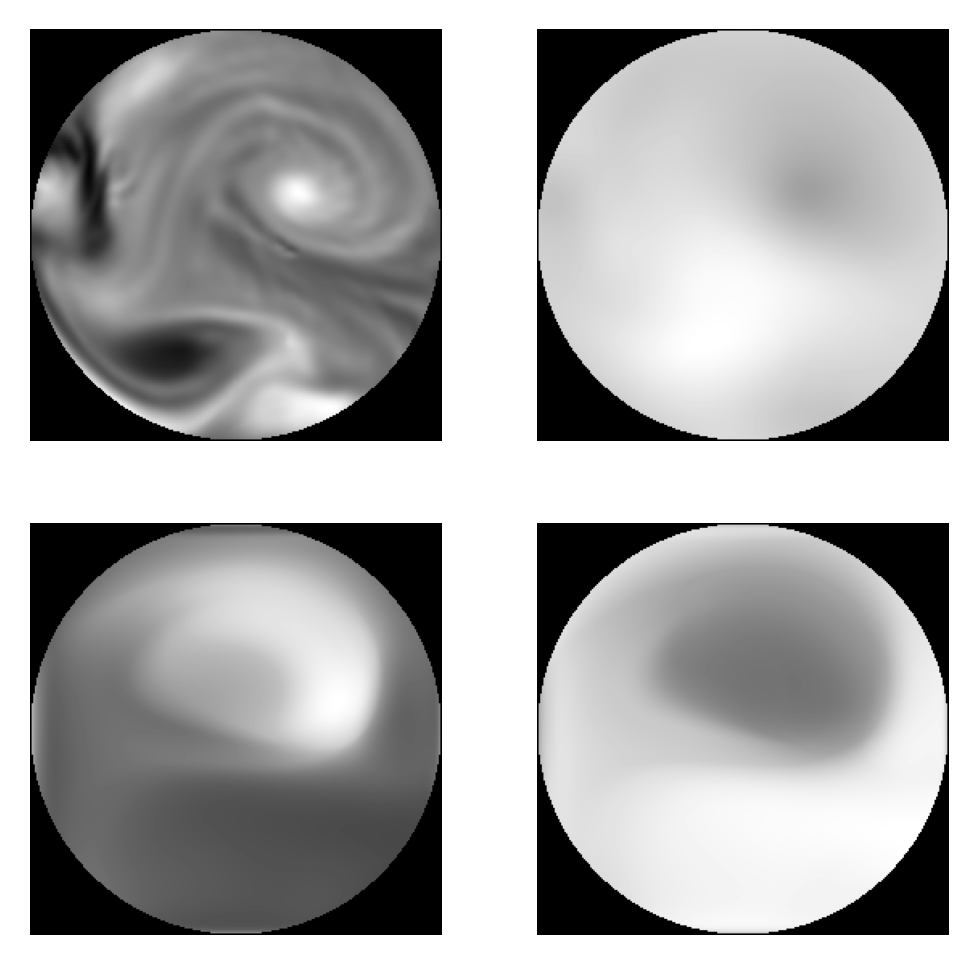

In [29]:
f = plt.figure(figsize=(4,4), dpi=300)
p = plt.subplot(2,2,1)
plt.imshow(real_batch[0,0,...], cmap='gray')
plt.axis('off')
p = plt.subplot(2,2,2)
plt.imshow(real_batch[0,1,...], cmap='gray')
plt.axis('off')

p = plt.subplot(2,2,3)
plt.imshow(fake_batch[0,0,...], cmap='gray')
plt.axis('off')
p = plt.subplot(2,2,4)
plt.imshow(fake_batch[0,1,...], cmap='gray')
plt.axis('off')

In [30]:
indices = np.random.choice(np.arange(32), 16, replace=False)

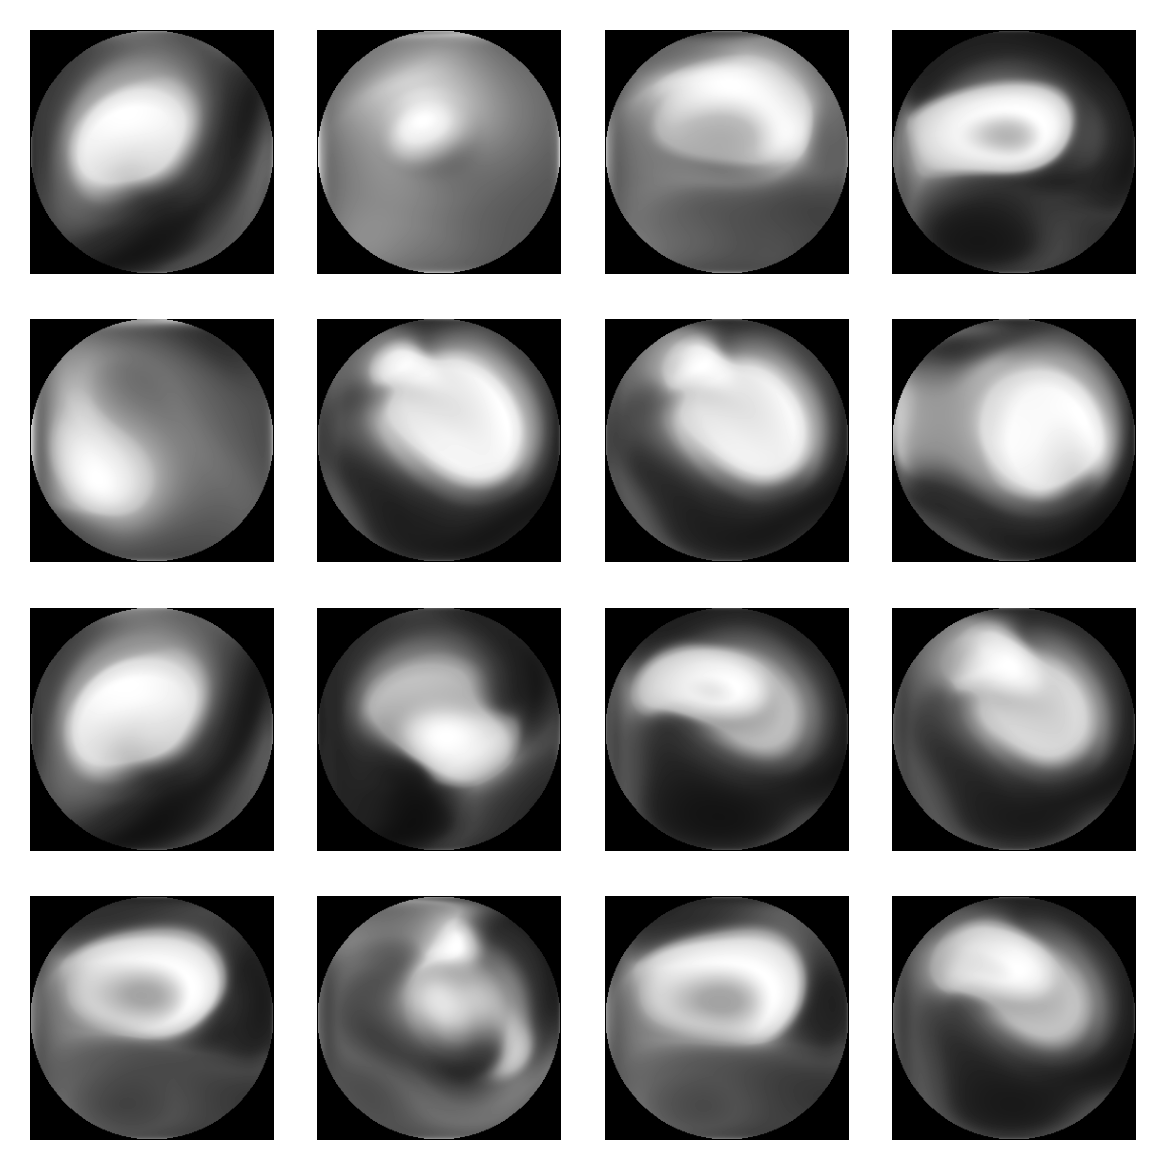

In [31]:
f = plt.figure(figsize=(4,4), dpi=300)

for i,idx in enumerate(indices):
    p = plt.subplot(4,4,i+1)
    plt.imshow(fake_batch[idx,0,...], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


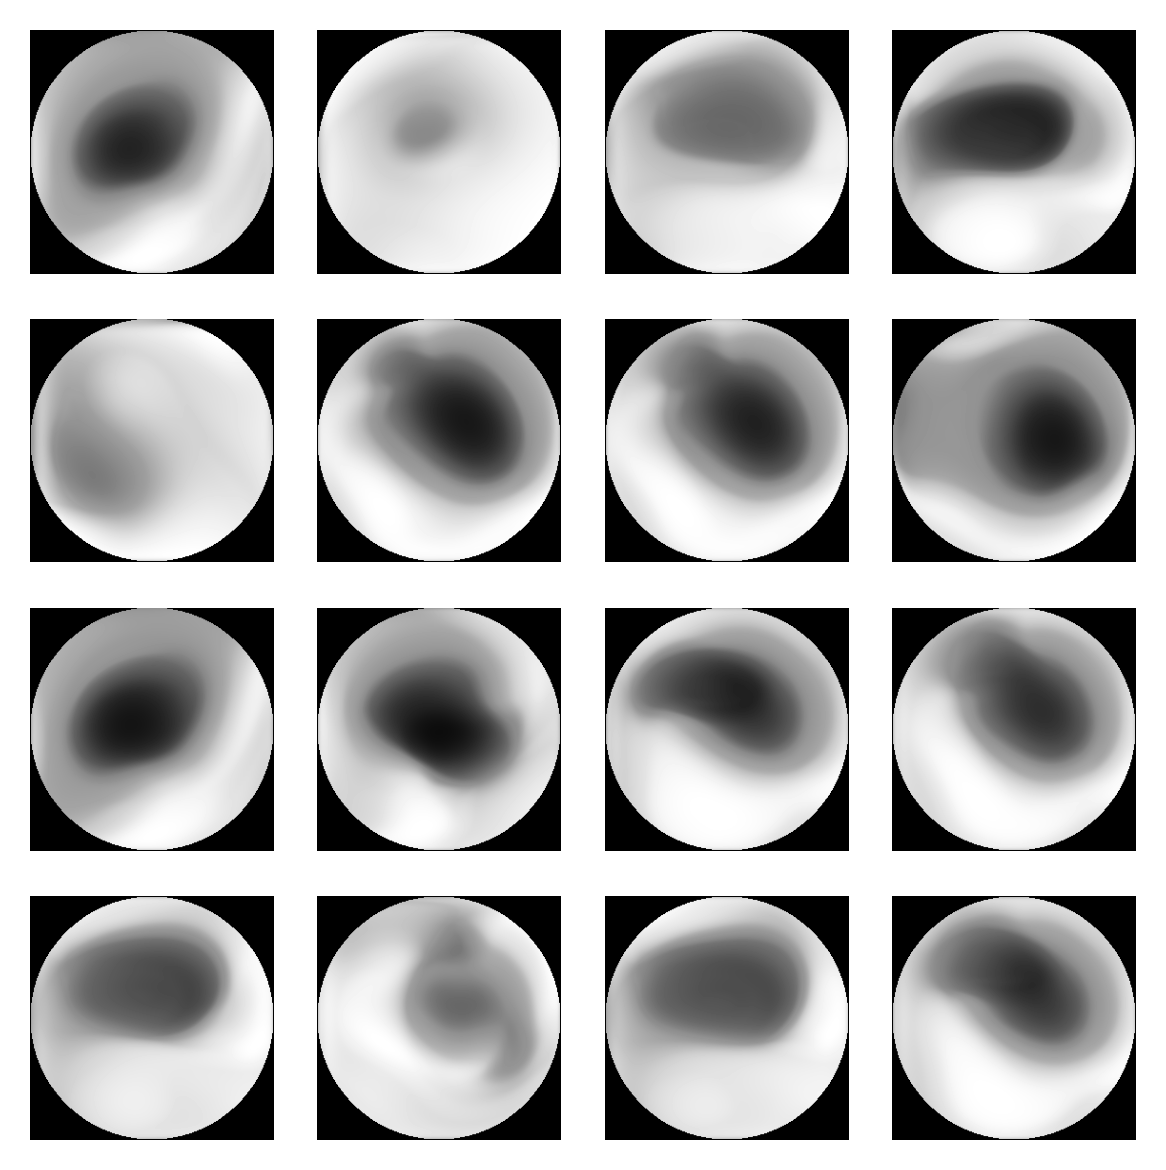

In [32]:
f = plt.figure(figsize=(4,4), dpi=300)

for i,idx in enumerate(indices):
    p = plt.subplot(4,4,i+1)
    plt.imshow(fake_batch[idx,1,...], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

### Использование обученного генератора $\mathcal{G}(\mathbb{\cdot})$

В этой части задания предлагается использовать генератор, обученный в первой части, для порождения примеров, похожих на представленные в обучающей выборке. Напомним, что векторы $z$ порождаются многомерным стандартным нормальным распределением, однако в этом задании следует изменить соотношение обычных экземпляров и экземпляров-аномалий. Этого можно добиться двумя способами:

- Сэмплировать с отклонением (отвержением) примеров. В этом случае векторы $z$ порождаются из стандартного нормального распределения, однако при этом экземпляры с нормой менее перцентиля уровня $98\%$ отклоняются с вероятностью, близкой к $98\%$ (вычислите, какова в точности должна быть вероятность отвержения, если Вы выбрали этот способ сэмплирования). Этот способ гарантирует получение сбалансированной выборки "обычных" и "аномальных" векторов $z$, однако не гарантирует равномерного сэмплирования внутри области "обычных" примеров;
- Сэмплировать равномерно в некоторой области, ограниченной нормой $z$: $z\leq z_{max}$. Здесь тоже должно быть задействовано сэмплирование с отвержением, однако условие отвержения будет другим. Если это ваш выбор, вычислите, каково должно быть $z_{max}$, чтобы выборка обычных и аномальных примеров была сбалансирована. Напомним: известно, что разделение обычных и аномальных примеров в пространстве $\mathbb{Z}$ проходит по значению нормы вектора $|z|_2=q_{0.98}(|z|_2)$. Обратите внимание, что эта величина зависит от размерности $n$ случайной величины $z$, поэтому правильнее писать $q_{0.98}(|z|_2, n)$.

**Подсказка**: поскольку $z$ распределена нормально с единичной матрицей ковариаций $\Sigma$, то каждая из компонент этого вектора распределена нормально с дисперсией $\sigma^2=1$; это означает, что $(|z|_2)^2=\sum_{j=1}^{n}z_j^2$ имеет распределение хи-квадрат, а $|z|_2=\sqrt{\sum_{j=1}^{n}z_j^2}$, соответственно, имеет распределение хи. Для вычисления величины $q_{0.98}(|z|_2, n)$ можно воспользоваться методами распределения, реализованными в библиотеке `scipy`: [`scipy.stats.chi`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi.html). 

После того, как мы знаем, в пределах каких значений $|z|_2$ лежат векторы $z$, отображающиеся в "обычные примеры", нужно научиться сэмплировать их равномерно. Для реализации равномерного сэмплирования в $n$-шаре можно воспользоваться функцией равномерного сэмплирования в многомерном $n$-кубе [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html#numpy.random.rand) с отвержением экземпляров по норме $|z|_2$

После этого следует научиться сэмплировать векторы за пределами этого $n$-шара радиусом $q_{0.98}(|z|_2, n)$. Например, можно сэмплировать равномерно из шара радиусом $R_{outer}=2^{1/n}$ с отвержением всех экземпляров внутри вложенного шара, содержащего "обычные" примеры.

**Подсказка**: можно сразу сэмплировать из шара радиусом $R_{outer}=q_{0.98}(|z|_2, n)*2^{1/n}$ и делить примеры на две категории: обычные (для которых $|z|_2\leq q_{0.98}(|z|_2, n)$) и аномальные (все остальные экземпляры).

### Об эффективном сэмплировании из $n$-мерного шара радиусом $R$

В тот момент, когда требуется порождать векторы, равномерно распределенные в $n$-мерном шаре радиуса $R$, в первую очередь на ум приходит равномерное сэмплирование из $n$-мерного куба со стороной $2R$ с отклонением примеров за пределами шара. Однако с возрастанием количества измерений **$n$** эффективность (скорость) алгоритма такого равномерного сэмплирования резко падает. Вместо этого лучше воспользоваться другим способом:

#### Псевдоалгоритм 1 - равномерного сэмплирования из $n$-мерного шара радиусом $R$
1. Породить $\mathbf{s}\in \mathbb{R}^n$ равномерно на поверхности $n-1$-мерной единичной сферы.
2. Породить $c\sim U[0,1]$ (из равномерного распределения с поддержкой $[0,1]$)
3. Вернуть вектор $\mathbf{b}=s*c^{1/n}*R$

При этом нужно еще уметь равномерно порождать векторы $\mathbf{s}\in \mathbb{R}^n$ на поверхности $n-1$-мерной единичной сферы. Для этого можно воспользоваться следующим алгоритмом:

#### Псевдоалгоритм 2 - равномерного сэмплирования из $n-1$-мерной единичной сферы
1. Породить $n$-мерный вектор, распределенный нормально с диагональной единичной матрицей ковариаций и нулевым вектором средних: $\mathbf{d}\sim\mathcal{N}(\mathbf{0}, \mathbb{I})$.
2. Вычислить $L_2$-норму вектора $\mathbf{d}$:
$$
|\mathbf{d}|_2=\sqrt{\sum_{i=1}^{n}d_i^2}
$$
3. Вернуть вектор-направление единичной длины $\tilde{\mathbf{d}}=\frac{\mathbf{d}}{|\mathbf{d}|_2}$

In [33]:
from scipy.stats import chi
R = chi.ppf(0.98, 128)
print(R)
#vect = np.random.normal(loc=0.0, scale=1.0, size=128)

12.7657014145933


In [34]:
#np.random.multivariate_normal(mean= [0 for i in range (128)], cov=np.eye(128), size=1)
vect = np.random.multivariate_normal(mean= [0 for i in range (128)], cov=np.eye(128), size=1)[0]
L2_norm = lambda x: np.sqrt(sum([i**2 for i in x]))
L2_norm(vect)

10.167028299022105

In [35]:
def SamplingUnitSphereUniform(ndim=2, nsamples=100):
    '''
    Эта функция должна порождать примеры, равномерно распределенные по единичной n-мерной сфере
        (см. псевдоалгоритм 2)
    '''
    ################################
    ###    YOUR CODE HERE        ###
    ################################
    d = []
    for i in range(nsamples):
      vect = np.random.multivariate_normal(mean= [0 for i in range (ndim)], cov=np.eye(ndim), size=1)[0]
      get_L2_norm = lambda x: np.sqrt(sum([i**2 for i in x]))
      L2_norm = get_L2_norm(vect)
      d.append(vect/L2_norm)
    return np.array(d)

In [36]:
def SamplingBallUniform(ndim=2, radius=1, nsamples=100):
    '''
    Эта функция должна порождать примеры, равномерно распределенные в единичном n-мерном шаре
        (см. псевдоалгоритм 1)
    '''
    ################################
    ###    YOUR CODE HERE        ###
    ################################
    b=[]
    s = SamplingUnitSphereUniform(ndim = ndim, nsamples=nsamples)
    for i in range(nsamples):
      c = np.random.uniform(low=0.0, high=1.0, size=1)**(1/ndim)
      b.append(s[i]*c*radius)
    b = np.array(b)
    return b

In [37]:
def SampleInnerAndOuterExamples(ndim=2, radius_inner=1, radius_outer=2, nsamples=100):
    '''
    В этой функции следует порождать примеры, равномерно распределенные в ndim-мерном шаре диаметром radius_outer
        и делить их на samples_inner ("обычные") и samples_outer ("аномальные")
        по норме векторов с пороговым значением radius_inner
    '''
    ################################
    ###    YOUR CODE HERE        ###
    ################################
    samples_inner = []
    samples_outer = []

    samples = SamplingBallUniform(ndim=ndim, radius=radius_outer, nsamples=nsamples)

    get_L2_norm = lambda x: np.sqrt(sum([i**2 for i in x]))
    for vect in samples:
      L2_norm = get_L2_norm(vect)
      if L2_norm <= radius_inner:
        samples_inner.append(vect)
      else:
        samples_outer.append(vect)
    samples_inner = np.array(samples_inner)
    samples_outer = np.array(samples_outer)

    return samples_inner, samples_outer

### Проверьте свою реализацию сэмплирования

В качестве проверки можно породить, скажем, 10000 примеров, равномерно распределенных в двумерном шаре (на круге, $n=2$). Внешний радиус нужно поставить в значение $R_{outer}=q_{0.98}(|z|_2, n)*2^{1/n}$, внутренний - в значение $R_{inner}=q_{0.98}(|z|_2, n)$

Ожидаемый результат:
- примеров `examples_inner` и `examples_outer` должно получиться примерно одинаковое количество;
- примеры распределены равномерно по кругу радиусом примерно 4;
- "обычные" (внутри круга радиусом $R_{inner}$) и "аномальные" (в кольце между окружностями радиусом $R_{inner}$ и $R_{outer}$) примеры визуально не перемешиваются;

In [38]:
examples_inner, examples_outer = SampleInnerAndOuterExamples(ndim=2,
                                                             radius_inner=stats.chi.ppf(0.98, 2),
                                                             radius_outer=stats.chi.ppf(0.98, 2)*np.sqrt(2),
                                                             nsamples=10000)
examples_inner.shape[0], examples_outer.shape[0]

(5032, 4968)

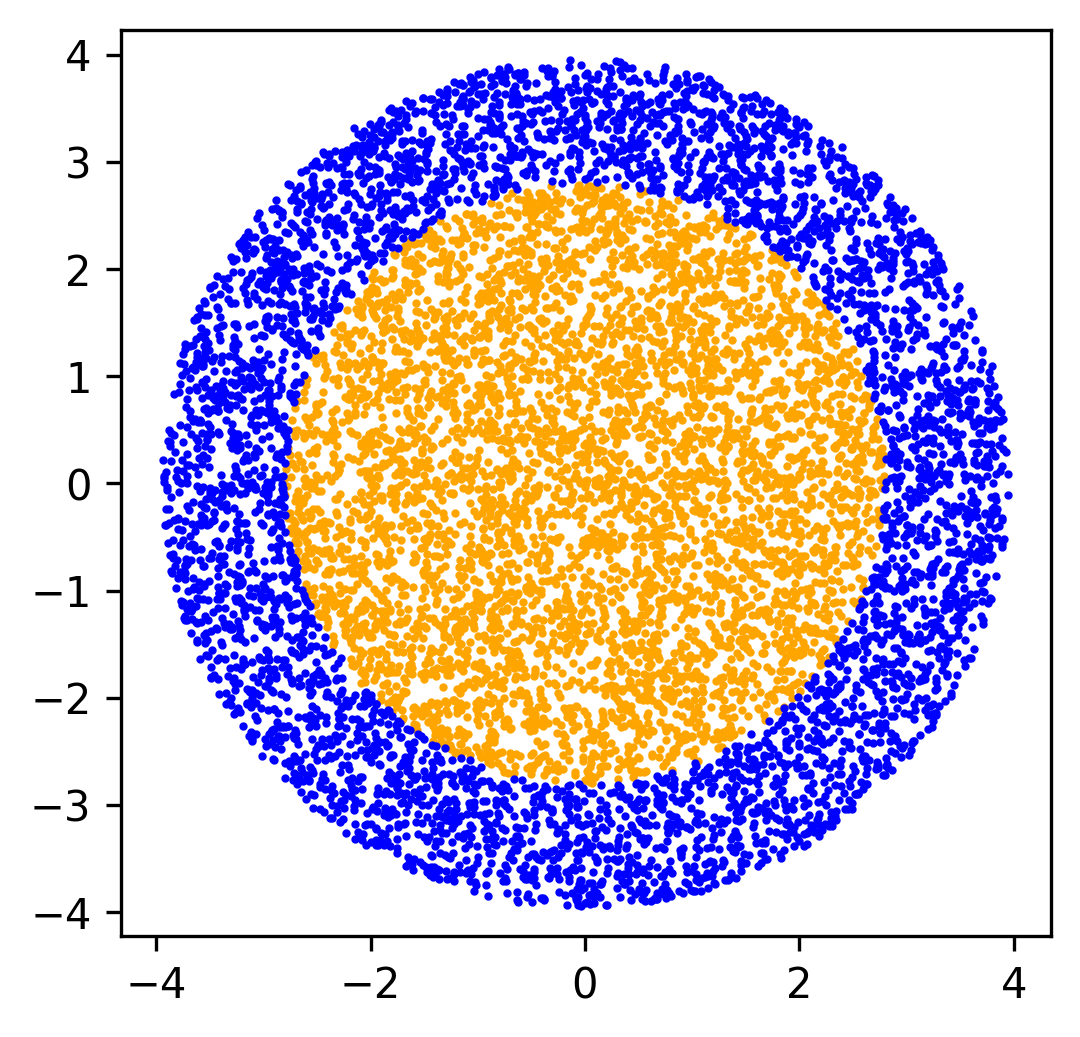

In [39]:
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(examples_inner[:,0], examples_inner[:,1], s=1, color='orange')
plt.scatter(examples_outer[:,0], examples_outer[:,1], s=1, color='blue')
_ = plt.axis('equal')

### Еще раз проверьте свою реализацию сэмплирования

В качестве второй проверки можно породить, скажем, 10000 примеров, равномерно распределенных в шаре высокой размерности (например, $n=128$). Внешний радиус нужно поставить в значение $R_{outer}=q_{0.98}(|z|_2, n)*2^{1/n}$, внутренний - в значение $R_{inner}=q_{0.98}(|z|_2, n)$

Ожидаемый результат:
- примеров `examples_inner` и `examples_outer` должно получиться примерно одинаковое количество;

In [40]:
chi_p98 = chi.ppf(0.99, 256) # YOUR CODE HERE - значение перцентиля уровня 98% распределения хи с количеством степеней свободы latent_dim
latent_dim = 256
print(chi_p98)

17.651072010700513


In [41]:
examples_inner, examples_outer = SampleInnerAndOuterExamples(ndim=latent_dim,
                                                             radius_inner=chi_p98,
                                                             radius_outer=chi_p98*np.power(2, 1/latent_dim),
                                                             nsamples=10000)
print(examples_inner.shape[0], examples_outer.shape[0])

4953 5047


# Внутри 98 перцентиля

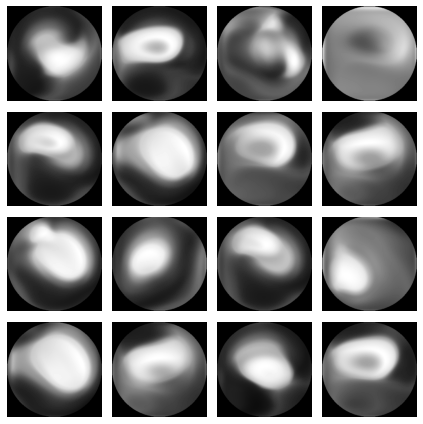

In [44]:
gen.eval()
indices = np.random.choice(np.arange(4000), 16, replace=False)
batch = Tensor(examples_inner[indices]).reshape((16,256,1,1))
fake_batch = gen(batch)

# Замечание: Не забудьте применить маску к данным, порождаемым генератором!
################################
###    YOUR CODE HERE        ###
################################
fake_batch = fake_batch.cpu().detach().numpy() * mask

plt.figure(figsize=(6,6))
for i,idx in enumerate(indices):
    p = plt.subplot(4,4,i+1)
    plt.imshow(fake_batch[i,0,...], cmap='gray')
    plt.axis('off')
plt.tight_layout()

# Вне 98 перцентиля

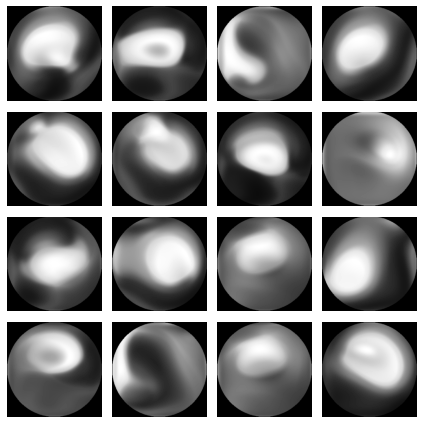

In [45]:
indices = np.random.choice(np.arange(4000), 16, replace=False)
fake_batch = gen(Tensor(examples_inner[indices]))

fake_batch = fake_batch.cpu().detach().numpy() * mask
plt.figure(figsize=(6,6))
for i,idx in enumerate(indices):
    p = plt.subplot(4,4,i+1)
    plt.imshow(fake_batch[i,0,...], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

# <b> Comment START </b>
Визуальное разделение картинок до и после 98 перцентиля отсутствует.    
# <b> Comment END

## Обучение классификатора $\mathcal{F}(\mathbf{\cdot})$

Итак, к этому моменту у вас должно быть все готово для обучения нейросети $\mathcal{F}(\mathbf{x})$, которая будет разделять "обычные" и "аномальные" примеры. Более конкретно, у вас должны быть готовы:
- обученный генератор - нейросетевая модель, преобразующая векторы $z\in\mathbb{Z}$ в примеры $x$ в пространстве признаков $\mathbb{X}$:
$$
\mathcal{G}(\cdot): \mathbb{Z}\to\mathbb{X}
$$
- механизм равномерного порождения "обычных" и "аномальных" векторов $z\in\mathbb{Z}$. Для этих векторов заранее известны метки, являются ли они обычными ($y=0$) или аномальными ($y=1$)

**ПРИМЕЧАНИЕ**
Генератор на этом этапе обучать не нужно! Не забудьте переключить его в режим исполнения!

In [ ]:
# При необходимости можно загрузить нужное состояние генератора
gen = Generator(n_inputs=latent_dim)
gen.load_state_dict(torch.load("drive/MyDrive/new_model_gen.pth"))
gen = gen.to(DEVICE)

Далее нужно описать классификатор. Это нейросеть, выполняющая задачу бинарной классификации. Скорее всего, вам захочется сделать ее свёрточной.

ПРИМЕЧАНИЕ: не забудьте, что здесь уже будет использоваться постановка задачи бинарной классификации. Подумайте, какими в этом случае должны быть:
- размерность выходного слоя классификатора;
- функция активации выходного слоя;
- функция потерь.

# <b> Comment START </b>
Использовал классификатор на основе обученного Resnet, веса которого дообучал на моём датасете.
# <b> Comment END

In [ ]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = True


resnet.fc = torch.nn.Identity()
resnet.conv1 = torch.nn.Identity()

for param in resnet.layer4.parameters():

  param.requires_grad = True


model = torch.nn.Sequential(nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
                            resnet,
                            nn.Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        
        ################################
        ###    YOUR CODE HERE        ###
        ################################
        self.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet = resnet
        self.lin1 = nn.Linear(in_features=512, out_features=2, bias=True)

    def forward(self, x):
        
        ################################
        ###    YOUR CODE HERE        ###
        ################################
        x = self.conv1(x)
        x = self.resnet(x)
        x = torch.sigmoid(self.lin1(x))
        
        return x

In [ ]:
clf = Classifier()
clf = clf.to(DEVICE)

In [ ]:
def train_classifier(model_gen: torch.nn.Module, 
                     model_clf: torch.nn.Module,
                     batch_size = 64,
                     batches_per_epoch = 128,
                     max_epochs = 512):
    
    '''
    В этой функции следует описать цикл оптимизации нейросети-классификатора.
    Не забудьте, что примеры для этой нейросети вы порождаете генератором, обученным выше.
    При этом шумовые векторы z для генератора вы порождаете, используя функции сбалансированного сэмплирования,
        описанные выше.
        
    Не забывайте и здесь применять маску к данным, порождаемым генератором!
    '''
    
    ################################
    ###    YOUR CODE HERE        ###
    ################################
    latent_dim = 128
    chi_p98 = chi.ppf(0.98, latent_dim)
    
    loss = nn.BCELoss()
    optimizer_clf = torch.optim.Adam(model_clf.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_clf, T_max = 10)
    val_loss_history = []
    clf_loss_history = []
    model_gen.eval()
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')
        
        model_clf.train()
        
        ####################################
        ###    YOUR CODE HERE            ###
        ### classifier optimization loop ###
        ####################################
        model_clf.zero_grad()

        examples_inner, examples_outer = SampleInnerAndOuterExamples(ndim=latent_dim,
                                                             radius_inner=chi_p98,
                                                             radius_outer=chi_p98*np.power(2, 1/latent_dim),
                                                             nsamples=batch_size)

        examples_inner = Tensor(examples_inner).to(DEVICE)
        examples_outer = Tensor(examples_outer).to(DEVICE)

        normal_batch = model_gen(examples_inner)
        anomaly_batch = model_gen(examples_outer)

        
        normal_batch = torch.mul(normal_batch, torch.tensor(mask).to(DEVICE))
        anomaly_batch = torch.mul(anomaly_batch, torch.tensor(mask).to(DEVICE))

        normal_scores = model_clf(normal_batch)
        anomaly_scores = model_clf(anomaly_batch)

        loss_clf = (loss(normal_scores, torch.tensor([[0.0,1.0] for i in range(len(normal_scores))]).to(DEVICE))*len(normal_scores) + 
                  loss(anomaly_scores, torch.tensor([[1.0,0.0] for i in range(len(anomaly_scores))]).to(DEVICE))*len(anomaly_scores))/(len(normal_scores) 
                                                                                                          + len(anomaly_scores))
        clf_loss_history.append(loss_clf)

        loss_clf.backward()
        optimizer_clf.step()        
        


        # model_clf.eval()
        # val_loss_epoch = 0.0
        
        # ####################################
        # ###    YOUR CODE HERE            ###
        # ###  classifier evaluation loop  ###
        # ####################################
            
        # val_loss_history.append(val_loss_epoch)
        # print('Eval loss on epoch %d: %f' % (epoch+1, val_loss_epoch))
        print('Eval loss on epoch %d: %f' % (epoch+1, loss_clf))
        
        lr_scheduler.step()

    torch.save(model_clf.state_dict(), "drive/MyDrive/new_model_clf.pth")
    val_loss_history = clf_loss_history 
    return val_loss_history

In [ ]:
val_loss_history = train_classifier(model_gen=gen,
                                    model_clf=clf,
                                    batch_size = 64,
                                    batches_per_epoch = 128,
                                    max_epochs = 1000)

Starting epoch 1 of 1000
Eval loss on epoch 1: 0.718417
Starting epoch 2 of 1000
Eval loss on epoch 2: 0.715435
Starting epoch 3 of 1000
Eval loss on epoch 3: 0.688186
Starting epoch 4 of 1000
Eval loss on epoch 4: 0.697258
Starting epoch 5 of 1000
Eval loss on epoch 5: 0.696270
Starting epoch 6 of 1000
Eval loss on epoch 6: 0.695408
Starting epoch 7 of 1000
Eval loss on epoch 7: 0.718141
Starting epoch 8 of 1000
Eval loss on epoch 8: 0.688565
Starting epoch 9 of 1000
Eval loss on epoch 9: 0.696015
Starting epoch 10 of 1000
Eval loss on epoch 10: 0.694525
Starting epoch 11 of 1000
Eval loss on epoch 11: 0.692324
Starting epoch 12 of 1000
Eval loss on epoch 12: 0.694510
Starting epoch 13 of 1000
Eval loss on epoch 13: 0.693718
Starting epoch 14 of 1000
Eval loss on epoch 14: 0.692027
Starting epoch 15 of 1000
Eval loss on epoch 15: 0.692549
Starting epoch 16 of 1000
Eval loss on epoch 16: 0.692964
Starting epoch 17 of 1000
Eval loss on epoch 17: 0.694646
Starting epoch 18 of 1000
Eval l

## Применение классификатора $\mathcal{F}(\mathbf{\cdot})$

Вы проделали большую работу! Теперь можно применить обученный классификатор для идентификации аномалий в данных.

Для этого нужно применить ее ко всем данным выборки.

- создайте новый экземпляр класса `DS`;
- создайте `dataloader` на основе этих данных. При этом не перемешивайте его: сейчас важен порядок обработки и ответов классификатора;
- в цикле примените классификатор $\mathcal{F}(\mathbf{\cdot})$ ко всем данным; сохраните ответы классификатора в массив;
- запишите индексы элементов выборки, которые классифицированы как аномальные, в массив `idx_anomalies`;
- воспользуйтесь заготовкой кода ниже для отображения объектов, которые классифицированы как аномальные и обычные.

In [ ]:
ds_test = DS('pv_data_projected_all.normed01.npy',
                   'hgt_data_projected_all.normed01.npy',
                   'mask_256.npy',
                   train_transforms)

In [ ]:
test_loader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=64)

In [ ]:
clf = Classifier()
clf.load_state_dict(torch.load('drive/MyDrive/new_model_clf.pth'))
clf = clf.to(DEVICE)

## Анализ результатов.

Примените обученный классификатор ко всем данным изначальной выборки.

Проанализируйте результаты:
- каково распределение вероятностей примеров быть аномальными, оцениваемое этим классификатором. Отобразите в виде гистограммы.
- Выберите пороговое значение для этих оценок вероятностей. Если применить разделение по этому пороговому значению, - каково количество примеров, отнесенных к обычным и к аномальным?
- Отобразите несколько состояний стратосферы, отнесенных к обычным, и несколько состояний, отнесенных к аномальным.

In [ ]:
for idx, real_batch in enumerate(train_loader):
    break

In [ ]:
clf(real_batch)

tensor([[0.5076, 0.4905],
        [0.5027, 0.4912],
        [0.4910, 0.5040],
        [0.4982, 0.4970],
        [0.4823, 0.5009],
        [0.5088, 0.4887],
        [0.4733, 0.5032],
        [0.4904, 0.4982],
        [0.4846, 0.5016],
        [0.4782, 0.5061],
        [0.4764, 0.5059],
        [0.5415, 0.4718],
        [0.5140, 0.4842],
        [0.4769, 0.5106],
        [0.4922, 0.5020],
        [0.4986, 0.5037],
        [0.5069, 0.4861],
        [0.4815, 0.5046],
        [0.4969, 0.4982],
        [0.5015, 0.4909],
        [0.4790, 0.5030],
        [0.5029, 0.4931],
        [0.4859, 0.5025],
        [0.4982, 0.5019],
        [0.4928, 0.4980],
        [0.4996, 0.4948],
        [0.4709, 0.5095],
        [0.4991, 0.4981],
        [0.5049, 0.4912],
        [0.4904, 0.4985],
        [0.4742, 0.5145],
        [0.5043, 0.4922]], device='cuda:0', grad_fn=<SigmoidBackward>)

# <b> Comment START </b>   
Как результат, видно, что обученный генератор не позволяет генерировать аномалии в зоне выброса из нормального распределения (за 98 перцентилем), что на корню обрубает все возможности для дальнейшей равномерной генерации аномалии и обучении классификатора на них (везде выдает вероятность в 50%).    
<b> :<     </b>     
Возможно такие задачи всё таки стоит решать с помощью чуть иного алгоритма (VAE/DINO)
# <b> Comment END